In [1]:
import osmnx as ox
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from src.utils import plot_path
import wandb
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
from torch import nn
from gym import spaces

# for rendering
import imageio
import IPython
from PIL import Image
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
%matplotlib inline


from pathlib import Path
home = str(Path.home())
graph_path = home + "/dev/GraphRouteOptimizationRL/datasets/osmnx/houston_drive_20000.graphml"
G = ox.load_graphml(graph_path)

In [2]:
neighbor = []
for i in G.nodes():
    neighbor.append(list(G.neighbors(i)))
neighbor_len = [len(i) for i in neighbor]

In [74]:
df = pd.read_csv("./datasets/tx_flood.csv")
df.head()

,Latitude,Longitude,stage_ft,name
0,30.22111,-97.79333,1.99,Williamson Creek at Manchaca Road at Austin
1,32.73278,-99.14028,3.78,Hubbard Creek at Albany
2,30.24444,-97.80194,1.73,Barton Creek at Loop 360
3,30.37194,-97.78445,2.47,Bull Creek at Loop 360
4,32.93298,-99.21539,5.99,Clear Fork Brazos River at Fort Griffin


In [71]:
# ox.utils_graph.get_route_edge_attributes(G, route, "travel_time")

In [75]:
from torch import nn

In [25]:
data = min(G.get_edge_data(153192125, 151461824).values(), key=lambda x: x["length"])

In [37]:
route = nx.shortest_path(G, 152964263, 151461824, weight="travel_time")

In [46]:
G.degree(152700529)

2

In [51]:
G.nodes(data=True)[152700529]

{'y': 29.748536,
 'x': -95.372895,
 'highway': 'traffic_signals',
 'street_count': 4}

In [2]:
adj_shape = (len(G.nodes), len(G.nodes))
observation_space = spaces.Dict({
            "current": spaces.Discrete(1000),
            "adj": spaces.Box(low=0, high=1, shape=adj_shape, dtype=np.float32),
            "length": spaces.Box(low=0, high=float("inf"), shape=adj_shape, dtype=np.float32),
            "speed_kph": spaces.Box(low=0, high=120, shape=adj_shape, dtype=np.float32),
            "travel_time": spaces.Box(low=0, high=float("inf"), shape=adj_shape, dtype=np.float32),
        })

In [100]:
observation_space.contains(A)

False

In [2]:
A = nx.to_numpy_array(G)

In [4]:
A.shape

(72486, 72486)

In [102]:
observation_space.items()

odict_items([('adj', Box([[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]], (1521, 1521), float32)), ('current', Discrete(1000)), ('length', Box([[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], [[inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 ...
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]
 [inf inf inf ... inf inf inf]], (1521, 1521), float32)), ('speed_kph', Box([[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], [[120. 120. 120. ... 120. 120. 120.]
 [120

In [5]:
A = nx.adjacency_matrix(G)

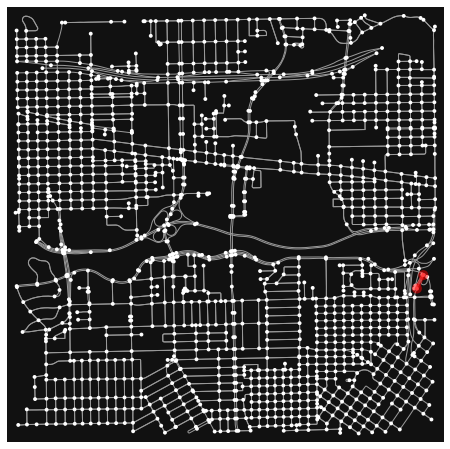

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [63]:
ox.plot_graph_route(G, [151488629, 151488633])

In [9]:
list(nx.neighbors(G, 151461824))

[153192125, 2229510607]

In [62]:
G.degree(152700529)

2

In [70]:
np.mean([1,2,3,4])

2.5

In [100]:
center_point = (29.72346214336903, -95.38599726549226) # houston museum/houston center points
center_point = (29.764050, -95.393030) # buffalo bayou park
G = ox.graph.graph_from_point(center_point, dist=2000, simplify = True, network_type='drive')

In [ ]:
nx.adjacency_matrix(G, weight="length").toarray()

In [40]:
neighbor_set = [x for x in G.neighbors(152264058)]
mask = np.isin(G.nodes(), neighbor_set, assume_unique=True).astype(int)

In [19]:
from gym import spaces

In [52]:
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)
G = ox.distance.add_edge_lengths(G)
# A = nx.adjacency_matrix(G, weight="speeds")
# nodes_dict = {idx:n for idx, n in enumerate(G.nodes())}
# D = A.toarray()

In [62]:
list(G.edges(data=True))[0]

(151366417,
 151366418,
 {'osmid': 15276431,
  'name': 'Castle Court Place',
  'highway': 'residential',
  'oneway': False,
  'length': 22.351,
  'speed_kph': 48.3,
  'travel_time': 1.7})

In [7]:
def remove_de_node(D, nodes_dict):
    # remove dead-end road
    de_nodes = [nodes_dict[idx] for idx, n in enumerate(D) if sum(n) <= 0]
    return de_nodes

de_nodes = remove_de_node(D, nodes_dict)
print(de_nodes)
G.remove_nodes_from(de_nodes)

dummy_route = []
# get dummy route by degree
for x, degree in nx.degree(G, weight="length"):
    if degree <= 0:
        print(x, degree)
        dummy_route.append(x)

A = G.adjacency()
# check items in adjacency
for n, nbrdict in A:
    print(n, nbrdict)
    break

In [ ]:
# for n in G.nodes():
#     print(n, )
#     break

for x in G.edges(data=True):
    # get all edges data
    print(x[2]['travel_time'])
    break

In [58]:
def plot_path(lat, long, origin_point):

    # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lat = [origin_point[0]],
        lon = [origin_point[1]],
        marker = {'size': 12, 'color':"red"}))
        

    # adding flood markers
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lat = lat,
        lon = long,
        marker = {'size': 12, 'color':"blue"}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': origin_point[0], 'lon': origin_point[1]},
                          'zoom': 13})
    fig.show()

In [1]:
df.head()

NameError: name 'df' is not defined

In [102]:
from collections import defaultdict
neg_list = defaultdict(float)
for x in df.values:
    neg_list[(x[0], x[1])] = x[2]

In [106]:
lat = []
long = []
for node in neg_list.keys():
    x1, y1 = node
    x2, y2 = center_point
    dist = ox.distance.great_circle_vec(x1, y1, x2, y2)
    if dist < 2200:
        print(node)
        lat.append(x1)
        long.append(y1)

(29.76, -95.40833)
(29.775, -95.39694)
(29.76023, -95.40855)
(29.77523, -95.39716)


In [107]:
# lat = df['Latitude'].values
# long = df['Longitude'].values
origin_point = center_point
plot_path(lat, long, origin_point)

In [141]:
mask = np.where([0,0,1,0,1,1,0,0,1])
np.random.choice([0,0,1,0,1,1,0,0,1])

0

In [140]:
mask

(array([2, 4, 5, 8]),)